 <img src="img/logo.jpg" alt="drawing" width="650"/>

<center>
    <h1 style="color:gray;font-size:25px;">INFO-F-440 - Algorithms for big data </h1>
</center>

<center>
    <h1 style="font-size:35px;">A Large-Scale k-Nearest Neighbor Classification Algorithm Based  </h1>
</center>


<h1 style="font-size:15px;">Reference  </h1>

Yunsheng Song, Xiaohan Kong, Chao Zhang, "A Large-Scale K-Nearest Neighbor Classification Algorithm Based on Neighbor Relationship Preservation", Wireless Communications and Mobile Computing, vol. 2022, Article ID 7409171, 11 pages, 2022. https://doi.org/10.1155/2022/7409171 

<h1 style="font-size:13px;">Libraries  </h1>

In [27]:
import pandas as pd
import random
import numpy as np
import math 
import timeit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KDTree,KNeighborsClassifier,NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

<h1 style="font-size:13px;">Basic Functions  </h1>

In [29]:
def normalize(dataset):
    #Normalize the dataset to the interval [0,1]
    normalized_df=(dataset.iloc[:,:-1]-dataset.iloc[:,:-1].min())/(dataset.iloc[:,:-1].max()-dataset.iloc[:,:-1].min())
    normalized_df['Target']=dataset.iloc[: , -1]
    return(normalized_df)

def euclidean_distance(row, x):
    distance = 0.0
    for i in range(len(x)):
        distance += (row[i] - x[i])**2
    return math.sqrt(distance)
    
def diff_list(list1,list2):
    differences=[]
    for listin in list1:
        if listin not in list2:
            differences.append(listin)
    return differences

def comm_list(list1,list2):
    commons=[]
    for listin in list1:
        if listin in list2:
            commons.append(listin)
    return commons

#From the course
def plotruntimes(functions,labels,r,trials=1,figsize=[3,3]):
    fig, ax = plt.subplots(figsize=figsize)
    for f,l in zip(functions,labels):
        Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
        ax.plot(r,Times,label=l)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: "+str(trials)+" trial"+("s" if trials>1 else ""))
    ax.legend()

<h1 style="font-size:13px;">NPR-KNN Algorithm</h1>

The algorithm NPR-KNN was described as follow in the paper for one instance in the testing set. The implementation (below - next cell) corresponds to each step of the pseudo code.

<img src="img/pseudo.JPG" alt="drawing" width="650" />

The parameters to set for npr_knn():
- test_row : a instance in the testing set
- subsets : n disjoint subsets of training set generated by MKC algorithm i.e. MiniBatch Function
- centers : n cluster centers of the n disjoint subsets generated by MKC algorithm i.e. MiniBatch Function
- num_neighbors : number of selected neighbors

The parameters for the function MiniBatch():
- n : number of classes in the dataset
- s : size of each subset
- data : the selected dataset

The function npr_knn() is meant to be used only for one instance.

In [31]:
#Create from data parameter, i.e. training set, n (= number of classes present in the training set) disjoint subsets 
#and generate the cluster centers
def MiniBatch (n,s,data):
    #Divide the set T into n disjoint T1 , T2 , ⋯, Tn using Mini-batch k-Means clustering algorithm 
    #and get n cluster centers set C = {c1 , c2 ,⋯, cn }
    process=data.copy()
    kmeans = MiniBatchKMeans(n_clusters=n, random_state=0, batch_size=s)
    process["Cluster"] = kmeans.fit_predict(process.iloc[: , :-1])
    k_centers=kmeans.cluster_centers_

    df_subsets = dict()
    for k, v in process.groupby('Cluster'):
        df_subsets[k] = v
    return(k_centers,df_subsets)

def npr_knn(test_row,subsets,centers,num_neighbors):     
    #Divide the set T into n disjoint T1 , T2 , ⋯, Tn using Mini-batch k-Means clustering algorithm 
    #and get n cluster centers set C = {c1 , c2 ,⋯, cn }
    subsets_tr=subsets.copy() 
    centers_C=centers.copy()

    #Initialization: Δ = {0}, k-nearest neighbor set NNk = ∅
    knn_set=list()
    delta=[0]

    #while (Δ ≠ ∅ or C ≠ ∅) do
    if len(delta)>0:
        while len(centers_C)>0:
            dist=list()
            knn_set_new=set()

            #Find the set Tυ according to the similarity between x and each instance of C, where υ = arg max d(x,c_j) 
            for i in range(len(centers_C)):
                y=euclidean_distance(centers_C[i],np.array(test_row)[0])
                dist.append(y) 
            index=dist.index(max(dist))

            #C = C − {c_v}
            centers_C=np.delete(centers_C, index, 0)   

            #Update k-nearest neighbor set NNk of x to generate a new set NNnew by comparing the similarity between x 
            #and each instance of Tυ
            clf = KNeighborsClassifier(n_neighbors=num_neighbors)
            clf.fit(subsets_tr[index].iloc[:,:-2], subsets_tr[index].iloc[:,-2])
            kneighbors_set=clf.kneighbors(test_row,return_distance=False)
            knn_npr=list(kneighbors_set[0])

            knn_npr_list=list()
            for ind in knn_npr:
                axes=subsets_tr[index].axes[0].tolist()
                knn_npr_list.append(axes[ind])
            predic_value=int(clf.predict(test_row))

            #Δ = (NNk − NNnew) U (NNnew − NNk)
            knn_set_new=knn_npr_list
            delta=diff_list(knn_set,knn_set_new)+diff_list(knn_set_new,knn_set)

            #NNk = NNnew
            knn_set=knn_set_new
            #Y=kneighbors_set[1]

            del subsets_tr[index]
            subsets_tr = {i: v for i, v in enumerate(subsets_tr.values())}

    return (knn_set,predic_value)

<h1 style="font-size:13px;">KD-Tree Algorithm</h1>

By definition, a KD Tree is a binary search tree where data in each node is a K-Dimensional point in space. In short, it is a space partitioning data structure for organizing points in a K-Dimensional space.
We decide to implement the KD tree algorithm to compare the implementation results, as the algorithm was mentioned in the paper.

The parameters to set for KD_tree_knn() :
- train : training set
- test_row : a instance in the testing set
- num_neighbors : number of selected neighbors
- size_subset : input for leaf_size in KD tree function

In [9]:
def KD_tree_knn(train,test_row, num_neighbors,size_subset):
    tree = KDTree(train.iloc[:,:-1], leaf_size=size_subset)              
    dist, index = tree.query(test_row, k=num_neighbors) 
    knn_kd=list(index[0])
    
    target_values=list()
    for ind in knn_kd:
        target_values.append(train.iloc[ind,-1])
    predic_value= max(set(target_values), key=target_values.count)
    
    return(list(knn_kd),predic_value)

<h1 style="font-size:13px;">General Function</h1>

This function regroups the two algorithms : NPR-KNN and KD-Tree. It allows to evaluate different scores for the chosen parameters.

The parameters to set for algorithms_knn ():
- train : training set
- test : testing set
- num_neighbors : number of selected neighbors (by default set to 7)
- size_subset : input for leaf_size in KD tree function or for the subset size in the MiniBatch() (to be used in npr_knn())
- method : either 'npr' or 'kd', or even 'all'. If 'npr' or 'all' is selected, the function divides first the training set into n disjoint subsets.
- training_ratio : Rtr = Ntr / N, where Ntr is the number of instances whose k-nearest neighbors in the divided subsets are the same as the training set and N is the size of the training set (by default set to False)
- testing_ratio : Rts = Nts / N, where Nts is the number of instances whose k-nearest neighbors in the divided subsets are the same as the testing set and N is the size of the testing set (by default set to False)
-accuracy : the number of correctly predicted data points out of all the data points (by default set to False)

In [44]:
def algorithms_knn (train,test,size_subset,method='npr',neighbors=7,training_ratio=False,testing_ratio=False,accuracy=False):   
    
    if method=='npr' or method == 'all':
        minibatch=MiniBatch(len(train.iloc[: , -1].unique()),size_subset,train)
        centers=minibatch[0]
        subsets=minibatch[1]
    acc=None
    training=None
    testing=None 
    n=0
    n_npr=0
    n_kd=0
    
    tr_n=0
    tr_n_npr=0
    tr_n_kd=0    
    
    predictions=list()
    predictions_npr=list()
    predictions_kd=list()
    predictions_knn=list()
     
    for i in range(len(test)):
        if testing_ratio==True or accuracy==True:
            clf = KNeighborsClassifier(n_neighbors=7)
            clf.fit(train.iloc[:,:-1], train.iloc[:,-1])
            knn_classic=clf.kneighbors(test.iloc[(i):(i+1),:-1],7,return_distance=False)
            knn_classic=list(knn_classic[0])
            if accuracy == True:
                target_values=list()
                for ind in knn_classic:
                    target_values.append(train_set.iloc[ind,-1])
                predictions_knn.append(max(set(target_values), key=target_values.count))
        if method == 'npr':
            npr_knn_result=npr_knn(test.iloc[(i):(i+1),:-1],subsets,centers, neighbors)
            predictions.append(npr_knn_result[1])
            if testing_ratio==True:
                length = comm_list(knn_classic,npr_knn_result[0])
                if(len(length)==7):
                    n+=1
                    
        if method == 'kd':
            kd_knn_result=KD_tree_knn(train,test.iloc[(i):(i+1),:-1],neighbors,size_subset)
            predictions.append(kd_knn_result[1])
            if testing_ratio==True:
                length = comm_list(knn_classic,kd_knn_result[0])
                if(len(length)==7):
                    n+=1  
                    
        if method == 'all': 
            npr_knn_result=npr_knn(test.iloc[(i):(i+1),:-1],subsets,centers, neighbors)
            kd_knn_result=KD_tree_knn(train,test.iloc[(i):(i+1),:-1],neighbors,size_subset)
           
            predictions_npr.append(npr_knn_result[1])
            predictions_kd.append(kd_knn_result[1])
            
            if testing_ratio==True: 
                if(len(comm_list(knn_classic,npr_knn_result[0]))==7):
                    n_npr+=1
                if(len(comm_list(knn_classic,kd_knn_result[0]))==7):
                    n_kd+=1
                    
    if training_ratio==True:
        for j in range(len(train)):
            claf = KNeighborsClassifier(n_neighbors=7)
            claf.fit(train.iloc[:,:-1], train.iloc[:,-1])
            tr_knn_classic=claf.kneighbors(train.iloc[(j):(j+1),:-1],7,return_distance=False)
            tr_knn_classic=list(tr_knn_classic[0])
            if method == 'npr':
                tr_npr_knn_result=npr_knn(train.iloc[(j):(j+1),:-1],subsets,centers, neighbors)
                tr_length = comm_list(tr_knn_classic,tr_npr_knn_result[0])
                if(len(tr_length)==7):
                    tr_n+=1 
                
            if method == 'kd':
                tr_kd_knn_result=KD_tree_knn(train,train.iloc[(j):(j+1),:-1],neighbors,size_subset)
                tr_length = comm_list(tr_knn_classic,tr_kd_knn_result[0])
                if(len(tr_length)==7):
                    tr_n+=1 
                    
            if method == 'all':  
                tr_npr_knn_result=npr_knn(train.iloc[(j):(j+1),:-1],subsets,centers, neighbors)
                tr_length_npr = comm_list(tr_knn_classic,tr_npr_knn_result[0])
            
                tr_kd_knn_result=KD_tree_knn(train,train.iloc[(j):(j+1),:-1],neighbors,size_subset)
                tr_length_kd = comm_list(tr_knn_classic,tr_kd_knn_result[0])
        
                if(len(tr_length_npr)==7):
                    tr_n_npr+=1
                if(len(tr_length_kd)==7):
                    tr_n_kd+=1        
        
    #Results
    if method == 'all':
        column=['NPR','KD']
        if training_ratio==True:
            training={column[0]:tr_n_npr/len(train),column[1]:tr_n_kd/len(train)}
            print("NPR - Training Ratio: ",training[column[0]])
            print("KD - Training Ratio: ",training[column[1]])
        
        if testing_ratio==True:
            testing={column[0]:n_npr/len(test),column[1]:n_kd/len(test)}
            print("NPR - Testing Ratio: ",testing[column[0]])
            print("KD - Testing Ratio: ",testing[column[1]])
        
        if accuracy==True:
            acc={column[0]:accuracy_score(test.iloc[:,-1],predictions_npr),
                 column[1]:accuracy_score(test.iloc[:,-1],predictions_kd),'KNN':accuracy_score(test.iloc[:,-1],predictions_knn)}
            print("KNN - Accuracy Score: ",acc['KNN'])
            print("NPR - Accuracy Score: ",acc[column[0]])
            print("KD - Accuracy Score: ",acc[column[1]])
        predictions={column[0]:predictions_npr,column[1]:predictions_kd}

    else:
        column=[method]
        if training_ratio==True:
            training={column[0]:tr_n/len(train)}
            print(method.upper()," -","Training Ratio: ",training[column[0]])
        if testing_ratio==True:
            testing={column[0]:n/len(test)}
            print(method.upper()," -","Testing Ratio: ",testing[column[0]])
        if accuracy==True:
            acc={method:accuracy_score(test.iloc[:,-1],predictions),'KNN':accuracy_score(test.iloc[:,-1],predictions_knn)}
            print("KNN - Accuracy Score: ",acc['KNN'])
            print(method.upper()," -","Accuracy Score: ", acc[method])
        predictions={column[0]:predictions}
    
    return(pd.DataFrame(predictions),pd.DataFrame(acc, index=[0]),
           pd.DataFrame(testing, index=[0]),pd.DataFrame(training, index=[0]))

<p style="font-size:16px;">   
The algorithm was evaluated on 5 different datasets:
</p>


||     Name       | Number Of Classes   |  Number Of Features   |Training Set Size  |Test Set Size  |
|:----------:|:----------:|-------------------|-----------------|-------------------|-----------------|
|1|**Breast Cancer** | 2  |30  | 341 (Split 60-40) | 228 (Split 60-40)|
|2|**Vehicle** | 4  |18  | 507 (Split 60-40) | 339 (Split 60-40)|
|3|**DNA** |  3  |180  | 2.000 | 1.186|
|4|**Satimage** |  6  |36  | 4.435 | 2.000|
|5|**Acoustic** |  3  |6  | 78.823 | 19.705|

<center>
<strong>Source</strong> StatLog (https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html)
    </center>

In [75]:
df_subsets=dict()
test_subsets=dict()
#BREAST-CANCER
database = load_breast_cancer()
dataset = pd.DataFrame(data=database.data, columns=database.feature_names)
dataset['target'] = database.target
df,test=train_test_split(dataset,test_size=0.4) 
df_subsets[0]=df
test_subsets[0]=test
#VEHICLE
dataset=pd.read_csv('data\dataset_vehicle.csv')
dataset=dataset.set_axis(dataset.iloc[:,0], axis=0).iloc[:,1:len(dataset)]
df,test=train_test_split(dataset,test_size=0.4)
df_subsets[1]=df
test_subsets[1]=test
#DNA
dataset_tr=pd.read_csv('data\dataset_dna.csv')
dataset_tr=dataset_tr.set_axis(dataset_tr.iloc[:,0], axis=0).iloc[:,1:len(dataset_tr)]
dataset_ts=pd.read_csv('data\dataset_dna (testing).csv')
dataset_ts=dataset_ts.set_axis(dataset_ts.iloc[:,0], axis=0).iloc[:,1:len(dataset_ts)]
df=dataset_tr
test=dataset_ts
df_subsets[2]=df
test_subsets[2]=test
#Acoustic
dataset_tr=pd.read_csv('data\dataset_acoustic.csv')
dataset_tr=dataset_tr.set_axis(dataset_tr.iloc[:,0], axis=0).iloc[:,1:len(dataset_tr)]
dataset_ts=pd.read_csv('data\dataset_acoustic (testing).csv')
dataset_ts=dataset_ts.set_axis(dataset_ts.iloc[:,0], axis=0).iloc[:,1:len(dataset_ts)]
df=dataset_tr
test=dataset_ts
df_subsets[4]=df
test_subsets[4]=test
#Satimage
dataset_tr=pd.read_csv('data\dataset_satimage.csv')
dataset_tr=dataset_tr.set_axis(dataset_tr.iloc[:,0], axis=0).iloc[:,1:len(dataset_tr)]
dataset_ts=pd.read_csv('data\dataset_satimage (testing).csv')
dataset_ts=dataset_ts.set_axis(dataset_ts.iloc[:,0], axis=0).iloc[:,1:len(dataset_ts)]
df=dataset_tr
test=dataset_ts
df_subsets[3]=df
test_subsets[3]=test

#parameter use to save results multiple times
copy=1

<p style="font-size:16px;">   
In order to have an idea of the implementation of our code for the NPR-KNN algorithm, we have beforehand save our results. Yet, the code used to generate results can be started once again if the answer of the below input is 'y'. Note to be pointed, running again the code can take a long time to run (mostly for the last dataset, 'Acoustic'), since both algorithms have linear time complexity. However, you can skip whether datasets you want by setting a maximum number from 1 to 5 based on the list above in the next input.
</p>

In [77]:
response = input('Do you want to print the saved results ? (if no, it will run the code again to evaluated the scores) [y/n]? ') 
if response=='y':
    names=['Breast-Cancer', 'Vehicle', 'DNA','Satimage','Acoustic']
    size=[500,5000]
    accuracy_res_500=pd.DataFrame()
    accuracy_res_5000=pd.DataFrame()
    testingratio_res_500=pd.DataFrame()
    testingratio_res_5000=pd.DataFrame()
    for name in names:
        one=pd.read_csv(r"all\all_Accuracy_" + str(name) +'_'+  str(size[0])+'.csv')
        two=pd.read_csv(r"all\all_Accuracy_" + str(name) +'_'+  str(size[1])+'.csv')
        one_ratio=pd.read_csv(r"all\all_TestingRatio_" + str(name) +'_'+  str(size[0])+'.csv')
        two_ratio=pd.read_csv(r"all\all_TestingRatio_" + str(name) +'_'+  str(size[1])+'.csv')
        accuracy_res_500=accuracy_res_500.append(one)
        accuracy_res_5000=accuracy_res_5000.append(two)
        testingratio_res_500=testingratio_res_500.append(one_ratio)
        testingratio_res_5000=testingratio_res_5000.append(two_ratio)
    accuracy_res_500=accuracy_res_500.iloc[: , 1:]
    accuracy_res_5000=accuracy_res_5000.iloc[: , 1:]
    accuracy_res_500.index= names
    accuracy_res_5000.index= names
    testingratio_res_500=testingratio_res_500.iloc[: , 1:]
    testingratio_res_5000=testingratio_res_5000.iloc[: , 1:]
    testingratio_res_500.index= names
    testingratio_res_5000.index= names
    print()
    print("ACCURACY - SUBSET SIZE 500")
    print(accuracy_res_500)
    print()
    print("ACCURACY - SUBSET SIZE 5000")
    print(accuracy_res_5000)
    print()
    print("TESTING RATIO - SUBSET SIZE 500")
    print(testingratio_res_500)
    print()
    print("TESTING RATIO - SUBSET SIZE 5000")
    print(testingratio_res_5000)
    
elif response=='n':
    max_data=input('What is the last dataset you want to take into account? (from 1 to 5 - list above) ')
    #PERFORMANCES - COMPARISON
    names=['Breast-Cancer', 'Vehicle', 'DNA','Satimage','Acoustic']
    #len(names)
    for j in range(0,int(max_data)):
        name=names[j]
        print()
        print("Selected Dataset : ",name)
        train_set=normalize(df_subsets[j])
        train_set=train_set.reset_index()
        train_set=train_set.iloc[: , 1:]
        test_set=normalize(test_subsets[j])
        test_set=test_set.reset_index()
        test_set=test_set.iloc[: , 1:]
        size=[500,5000]
        for s in size:
            print()
            print("Size of Subset : ",s)
            pred,acc,testing,training=algorithms_knn(train_set,test_set,s,method='all',
                                             training_ratio=False,testing_ratio=True,accuracy=True)
            pred.to_csv(r"scores\all_Predictions_" + str(name) +'_'+  str(s)+ '_'+str(copy)+'.csv')
            acc.to_csv(r"scores\all_Accuracy_" + str(name) +'_'+  str(s)+ '_'+str(copy)+'.csv')
            testing.to_csv(r"scores\all_TestingRatio_" + str(name) +'_'+  str(s)+ '_'+str(copy)+'.csv')
            training.to_csv(r"scores\all_TrainingRatio_" + str(name) +'_'+  str(s)+ '_'+str(copy)+'.csv')  
            
    copy+=1 #to save each time it runs the code
    
else:
    print("Error : the first answer should be either 'y' or 'n'")

Do you want to print the saved results ? (if no, it will run the code again to evaluated the scores) [y/n]? n
What is the last dataset you want to take into account? (from 1 to 5 - list above) 1

Selected Dataset :  Breast-Cancer

Size of Subset :  500
NPR - Testing Ratio:  0.7850877192982456
KD - Testing Ratio:  1.0
KNN - Accuracy Score:  0.9342105263157895
NPR - Accuracy Score:  0.9210526315789473
KD - Accuracy Score:  0.9342105263157895

Size of Subset :  5000
NPR - Testing Ratio:  0.7850877192982456
KD - Testing Ratio:  1.0
KNN - Accuracy Score:  0.9342105263157895
NPR - Accuracy Score:  0.9210526315789473
KD - Accuracy Score:  0.9342105263157895


<p style="font-size:16px;">   
In this part, you can select only one dataset to run whether algorithm you want with the function algorithms_knn().
</p>

In [64]:
dataset_name = input('Choose a number (from 1 to 5) based on the list above to select one of the datasets: ')
dataset_names=['Breast-Cancer', 'Vehicle', 'DNA','Satimage','Acoustic']
index=int(dataset_name)
if index <=4 :    
    print()
    print('You choose : ',dataset_names[index-1],'DataSet')
    #BREAST-CANCER
    df=df_subsets[index-1]
    test=test_subsets[index-1]
    #As mentioned in the paper, the selected dataset has been scaled to the interval [0,1]
    train_set=normalize(df)
    train_set=train_set.reset_index()
    train_set=train_set.iloc[: , 1:]
    test_set=normalize(test)
    test_set=test_set.reset_index()
    test_set=test_set.iloc[: , 1:]
    
else:
    print()
    print('No DataSet found')

Choose a number (from 1 to 5) based on the list above to select one of the datasets: 2

You choose :  Vehicle DataSet


In [49]:
#Parameter
size_subset=input('Choose the size of the subset for the MKC algorithm (e.g. 50,100,1000,2000,5000): ')
#Since most of our dataset are small compared to the one used in the paper, it shows better results for small values of the 
#parameter 'size_subset'

#Algorithm
print("The Selected Data : ",dataset_names[index-1])
print("Evaluating...")
predictions,accuracy,testing,training=algorithms_knn(train_set,test_set,int(size_subset),method='npr',
                                                     training_ratio=False,testing_ratio=True,accuracy=True)

Choose the size of the subset for the MKC algorithm (e.g. 50,100,1000,2000,5000): 5
The Selected Data :  Vehicle
Evaluating...
NPR  - Testing Ratio:  0.881578947368421
KNN - Accuracy Score:  0.9824561403508771
NPR  - Accuracy Score:  0.9692982456140351


Vehicle


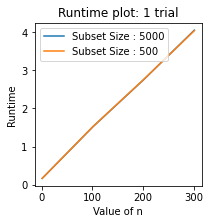

In [65]:
#To test the time complexity of the NPR-KNN algorithm. Theoretically, the paper goes by saying 
#that the algorithm as a linear time complexity i.e. O(n)
def h(n,m):
    return [algorithms_knn(train_set,test_set.iloc[0:n,:],int(m),method='npr')]

print(str(dataset_names[index-1]))
plotruntimes([lambda n:h(n,5000),lambda n:h(n,500)],["Subset Size : 5000","Subset Size : 500"],range(1,len(test_set),100),1)
#plt.savefig(r"runtime\_" + str(dataset_names[index-1]) +'.png')